In [1]:
import copy
import os
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

In [2]:
os.listdir('./train/')

['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']

In [3]:
# training dataset path
training_dataset_path = './train/'

# path to each dataset
healthy_banana_dataset_path = './train/healthy/'
cordona_banana_dataset_path = './train/cordana/'
pestalotiopsis_banana_dataset_path = './train/pestalotiopsis/'
sigatoka_banana_dataset_path = './train/sigatoka/'

# Data Preprocessing

In [4]:
dataset = torchvision.datasets.ImageFolder(
    root=training_dataset_path, 
    transform=transforms.Compose([transforms.ToTensor()])
)

data_loader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=32, 
    shuffle=True
)

In [5]:
# Check the first batch from the DataLoader
images, _ = next(iter(data_loader))
class_names = dataset.classes
dataset_size = len(dataset)

# Print class names
print(f'Classes: {class_names}')

# Print shape details
print(f"Batch Size: {images.shape[0]}")
print(f"Channels: {images.shape[1]}")
print(f"Height of Image: {images.shape[2]}")
print(f"Width of Image: {images.shape[3]}")  

# Count total images in dataset
dataset_size = len(dataset)

print(f"Total Images: {dataset_size}")

Classes: ['cordana', 'healthy', 'pestalotiopsis', 'sigatoka']
Batch Size: 32
Channels: 3
Height of Image: 224
Width of Image: 224
Total Images: 843


In [6]:
def show_dataset(dataset):
    # batch_size = number of images shown
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=5, shuffle=True) 
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=5)
    title = [class_names[x] for x in labels]

    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

# Show Dataset without Transformations

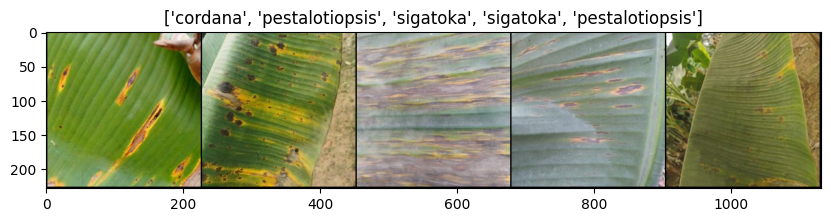

In [7]:
# show dataset with no transformation
train_dataset_no_transform = torchvision.datasets.ImageFolder(
    root=training_dataset_path, 
    transform=transforms.Compose([transforms.ToTensor()])
)
show_dataset(train_dataset_no_transform)

# Data Transformation

In [8]:
# use mean and std based on pretrained weights of pretrained model
# ImageNet Statistics
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [9]:
# no need to resize! shape is already 224 x 224 px
train_transform = transforms.Compose([
    # convert images to pytorch tensors
    transforms.ToTensor(), 
    # randomly flips images for augmentation
    transforms.RandomHorizontalFlip(),  
    # normalize images based on ImageNet mean and std
    transforms.Normalize(mean, std) 
])

# Show Dataset with Transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.64].


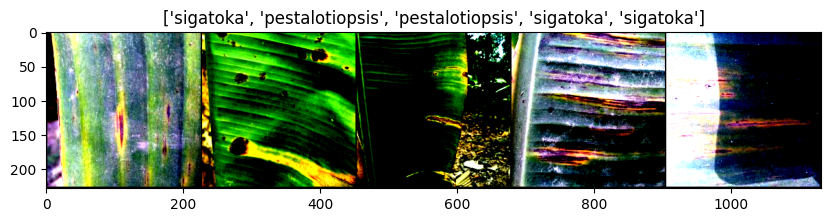

In [10]:
# show dataset with transformations
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=train_transform)
show_dataset(train_dataset)

# Model

In [11]:
# train_loader = transformed and final training dataset 
# change batch_size depending on the performance of the model
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=32, 
    shuffle=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cpu device


## Setup Pretrained Model

In [12]:
import torchvision.models as models

resnet152_model = models.resnet152(weights='DEFAULT')
# https://pytorch.org/vision/0.17/models/generated/torchvision.models.resnet152.html#torchvision.models.ResNet152_Weights

num_features = resnet152_model.fc.in_features
num_classes = 4 # healthy, cordona, pestalotiopsis, sigatoka
resnet152_model.fc = nn.Linear(num_features, num_classes)

# Move model to device
resnet152_model = resnet152_model.to(device)

# https://pytorch.org/docs/stable/nn.html#loss-functions 
# try other options
loss_function = nn.CrossEntropyLoss()

# SGD = Stochastic Gradient Descent
# lr = learning rate (test values from [0.001, 0.01] or experiment others)
optimizer = optim.SGD(
    resnet152_model.parameters(), 
    lr=0.001, 
    momentum=0.9, 
    weight_decay=0.003
)

# Decay LR by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train Model

In [13]:
def train_model(model, train_loader, scheduler, device, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += (predicted == labels).sum().item()
        
        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_accuracy = 100 * running_corrects / dataset_size

        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')

        if epoch_accuracy > best_acc:
            best_acc = epoch_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    model.load_state_dict(best_model_wts)
    return model

## Evaluate Model

In [14]:
def evaluate_model(model, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            running_corrects += (labels == predicted).sum().item()

    epoch_loss = running_loss / dataset_size
    epoch_accuracy = 100 * running_corrects / dataset_size

    print(f"Eval Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
    print(f'Got {running_corrects} out of {dataset_size} images correctly')
    print('Eval finished')

    return epoch_loss, epoch_accuracy

In [ ]:
best_model = train_model(resnet152_model, train_loader, step_lr_scheduler, device, loss_function, optimizer, 20)

# Practice Test Dataset from Kaggle

In [ ]:
# Dataset from https://www.kaggle.com/datasets/shifatearman/bananalsd?resource=download

# Original + Augmented
test_dataset_path = './prac_test/'

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
]),

test_dataset = torchvision.datasets.ImageFolder(
    root=test_dataset_path, 
    transform=test_transform
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=32, 
    shuffle=True
)

evaluate_model(best_model, test_loader, device)